# Практическое задание к уроку 4

In [177]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn import metrics

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
import tensorflow_hub as hub
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

### Часть 1. Тональность текста

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [106]:
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.1.0
Eager mode:  True
Hub version:  0.10.0
GPU is available


In [26]:
#url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

#dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
#                                    untar=True, cache_dir='.',
#                                    cache_subdir='')

#dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

#train_dir = os.path.join(dataset_dir, 'train')
#os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsup',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

In [27]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [28]:
import glob
reviews_train = []
labels_train=[]
for file_name in glob.glob("aclImdb/train/pos/*.txt"):
    with open(file_name, 'r', encoding='utf8') as f:
        reviews_train.append([f.read().strip(),1])
        labels_train.append(1)
for file_name in glob.glob("aclImdb/train/neg/*.txt"):
    with open(file_name, 'r', encoding='utf8') as f:
        reviews_train.append([f.read().strip(),0])
        labels_train.append(0)

labels_test=[]
reviews_test = []
for file_name in glob.glob("aclImdb/test/pos/*.txt"):
    with open(file_name, 'r', encoding='utf8') as f:
        reviews_test.append([f.read().strip(),1])
        labels_test.append(1)
for file_name in glob.glob("aclImdb/test/neg/*.txt"):
    with open(file_name, 'r', encoding='utf8') as f:
        reviews_test.append([f.read().strip(),0])
        labels_test.append(0)

In [29]:
train=pd.DataFrame(reviews_train,columns=['text','label'])
test=pd.DataFrame(reviews_test,columns=['text','label'])

CountVectorizer 

In [31]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(train['text'],train['label'])
xtrain_count =  count_vect.transform(train['text'])
xtest_count =  count_vect.transform(test['text'])

In [28]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid,valid_y, is_neural_net=False):
    classifier.fit(feature_vector_train, label)
    
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y)

In [33]:
accuracy = train_model(linear_model.LogisticRegression(), xtrain_count, train['label'], xtest_count,test['label'])
print("LR, Count Vectors: ", accuracy)

LR, Count Vectors:  0.86836


TfidfVectorizer

In [34]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(train['text'],train['label'])
xtrain_tfidf =  tfidf_vect.transform(train['text'])
xvalid_tfidf =  tfidf_vect.transform(test['text'])

In [35]:
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train['label'], xvalid_tfidf,test['label'])
print("LR, Tfid Vectors: ", accuracy)

LR, Tfid Vectors:  0.8854


2. Обучить вашу архитектуре сети возможно туже что и была на занятии проверить
•	взять предобученный эмбединг(к примеру word2vec) и загрузить в слой Embedding
•	взять слой Embedding без предобученных весов
Сравнить все подходы в том числе и полносвязанную сеть что лучше отработало


In [36]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [51]:
max_features = 10000
sequence_length = 250
embedding_dim = 16

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [52]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim,),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(145),
  layers.Dense(1)])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 145)               2465      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 146       
Total params: 162,627
Trainable params: 162,627
Non-trainable params: 0
________________________________________________

In [62]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['binary_accuracy']) 

In [94]:
batch_size=32
raw_train = tf.data.Dataset.from_tensor_slices((train['text'],train['label']))
raw_test = tf.data.Dataset.from_tensor_slices((test['text'],test['label']))

raw_train_ds = raw_train.batch(batch_size)
raw_test_ds=raw_test.batch(batch_size)

In [95]:
train_ds = raw_train_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [96]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [66]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs)

Train for 782 steps, validate for 782 steps
Epoch 1/10
782/782 [==============================] - 15s 20ms/step - loss: 0.5423 - binary_accuracy: 0.7746 - val_loss: 2.3691 - val_binary_accuracy: 0.5000
Epoch 2/10
782/782 [==============================] - 11s 14ms/step - loss: 0.3583 - binary_accuracy: 0.8643 - val_loss: 2.2501 - val_binary_accuracy: 0.5000
Epoch 3/10
782/782 [==============================] - 12s 16ms/step - loss: 0.3844 - binary_accuracy: 0.8434 - val_loss: 2.3562 - val_binary_accuracy: 0.5000
Epoch 4/10
782/782 [==============================] - 12s 15ms/step - loss: 0.3758 - binary_accuracy: 0.8455 - val_loss: 2.4072 - val_binary_accuracy: 0.5000
Epoch 5/10
782/782 [==============================] - 13s 17ms/step - loss: 0.3855 - binary_accuracy: 0.8459 - val_loss: 2.1964 - val_binary_accuracy: 0.5000
Epoch 6/10
782/782 [==============================] - 12s 15ms/step - loss: 0.3924 - binary_accuracy: 0.8330 - val_loss: 2.2465 - val_binary_accuracy: 0.5000
Epoch 7/

In [68]:
loss, accuracy = model.evaluate(train_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 4s 5ms/step - loss: 2.4870 - binary_accuracy: 0.5000
Loss:  2.4869581636117624
Accuracy:  0.5


 взять предобученный эмбединг(к примеру word2vec) и загрузить в слой Embedding 

In [89]:
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
embedding_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)


In [98]:
model = tf.keras.Sequential()
model.add(embedding_layer)
model.add(tf.keras.layers.Dense(145, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense_6 (Dense)              (None, 145)               3045      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 146       
Total params: 403,211
Trainable params: 403,211
Non-trainable params: 0
_________________________________________________________________


In [101]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [104]:
epochs = 10
history = model.fit(
    raw_train_ds,
    validation_data=raw_test_ds,
    epochs=epochs)

Train for 782 steps, validate for 782 steps
Epoch 1/10
782/782 [==============================] - 18s 24ms/step - loss: 0.1954 - accuracy: 0.9717 - val_loss: 6.3246 - val_accuracy: 0.5002
Epoch 2/10
782/782 [==============================] - 18s 23ms/step - loss: 0.2908 - accuracy: 0.9458 - val_loss: 3.8305 - val_accuracy: 0.5020
Epoch 3/10
782/782 [==============================] - 18s 23ms/step - loss: 0.2077 - accuracy: 0.9469 - val_loss: 2.8921 - val_accuracy: 0.5016
Epoch 4/10
782/782 [==============================] - 18s 23ms/step - loss: 0.1740 - accuracy: 0.9480 - val_loss: 2.8517 - val_accuracy: 0.5027
Epoch 5/10
782/782 [==============================] - 18s 23ms/step - loss: 0.1500 - accuracy: 0.9541 - val_loss: 2.4507 - val_accuracy: 0.5048
Epoch 6/10
782/782 [==============================] - 18s 23ms/step - loss: 0.1292 - accuracy: 0.9582 - val_loss: 2.4041 - val_accuracy: 0.5068
Epoch 7/10
782/782 [==============================] - 18s 23ms/step - loss: 0.1125 - accurac

In [107]:
loss, accuracy = model.evaluate(raw_test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 8s 10ms/step - loss: 2.2536 - accuracy: 0.5428
Loss:  2.253603813271826
Accuracy:  0.5428


### Часть 2 Классификация текста

Задание 1.
Построим модель LogisticRegression, используя Bag-of-Words признаки для столбца combine_df['tweet_stemmed']. 
- Поделим Bag-of-Words признаки на train, test (train заканчивается на 31962 строке combine_df)
- Ответами является столбец train_df['label']
- Рассчитаем predict_proba, приведем prediction в в бинарный вид: если предсказание >= 0.3 то 1, иначе 0, тип заменим на int
- Рассчитаем f1_score 


In [402]:
row_split=31962

In [403]:
combine_df=pd.read_pickle('tweet_tokens')
combine_df.head(3)

,id,label,tweet,clean_tweet,tweet_token,tweet_token_filtered,tweet_stemmed,tweet_lemmatized
0,1,0.0,@user when a father is dysfunctional and is s...,when father is dysfunctional and is so selfish...,"[when, father, is, dysfunctional, and, is, so,...","[father, dysfunctional, selfish, drags, kids, ...","[father, dysfunctional, selfish, drags, kids, ...","[father, dysfunctional, selfish, drags, kids, ..."
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit cannot use cause they d...,"[thanks, for, lyft, credit, can, not, use, cau...","[thanks, lyft, credit, use, cause, offer, whee...","[thanks, lyft, credit, use, cause, offer, whee...","[thanks, lyft, credit, use, cause, offer, whee..."
2,3,0.0,bihday your majesty,bihday your majesty,"[bihday, your, majesty]","[bihday, majesty]","[bihday, majesty]","[bihday, majesty]"


In [404]:
def split_data(data,row_split,column):
    train=data[[column]][:row_split]
    test=data[[column]][row_split:]
    train[column]=train[column].apply(lambda x: ' '.join([ch for ch in x]))
    test[column]=test[column].apply(lambda x: ' '.join([ch for ch in x]))
    y_train=data['label'][:row_split]
    y_test=data['label'][row_split:]
    return train, test, y_train, y_test 

In [405]:
train, test, y_train, y_test=split_data(combine_df,row_split=row_split,column='tweet_stemmed')
train.tail(3)


,tweet_stemmed
31959,listening sad songs monday morning otw work sad
31960,sikh temple vandalised calgary wso condemns act
31961,thank follow


In [406]:
from sklearn.feature_extraction.text import  CountVectorizer
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm

In [407]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(train)

xtrain_count =  count_vect.transform(train['tweet_stemmed'])
xvalid_count =  count_vect.transform(test['tweet_stemmed'])

In [475]:
def get_predict_proba(xtrain,train_y):
    lr=linear_model.LogisticRegression()
    lr.fit(xtrain,train_y)
    predict_proba=lr.predict_proba(xtrain)
    predict=[]
    for  i,val in iter(predict_proba):
        if val>=0.3:
            predict.append(1)
        else:
            predict.append(0)
            
    return predict

In [454]:
predict=get_predict_proba(xtrain_count,y_train)

In [455]:
result=pd.DataFrame(y_train)
result['predict_count_stemmed']=predict

In [456]:
metrics.f1_score(result['label'],result['predict_count_stemmed'])

0.1310957782715472

2.

In [457]:
train, test, y_train, y_test=split_data(combine_df,row_split=row_split,column='tweet_lemmatized')
train.tail(3)

,tweet_lemmatized
31959,l i s t e n i n g s a d s o n g s m o n ...
31960,s i k h t e m p l e v a n d a l i s e d ...
31961,t h a n k f o l l o w


In [458]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(train)

xtrain_count =  count_vect.transform(train['tweet_lemmatized'])
xvalid_count =  count_vect.transform(test['tweet_lemmatized'])
predict=get_predict_proba(xtrain_count,train_y)

In [459]:
result['predict_count_lemma']=predict

In [460]:
metrics.f1_score(result['label'],result['predict_count_lemma'])

0.1310957782715472

TfidfVectorizer

Задание 2.
Построим модель LogisticRegression, используя TF-IDF признаки для столбца combine_df['tweet_stemmed']. 
- Поделим TF-IDF признаки на train, test (train заканчивается на 31962 строке combine_df)
- Ответами является столбец train_df['label']
- Рассчитаем predict_proba, приведем prediction в в бинарный вид: если предсказание >= 0.3 то 1, иначе 0, тип заменим на int
- Рассчитаем f1_score 

Повторим аналогично для столбца combine_df['tweet_lemmatized'].


In [476]:
column='tweet_stemmed'

In [477]:
train, test, y_train, y_test=split_data(combine_df,row_split=row_split,column=column)

In [478]:

tdif_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}')
tdif_vect.fit(train[column])

xtrain_tdif =  tdif_vect.transform(train[column])
xvalid_tdif =  tdif_vect.transform(test[column])

In [479]:
predict=get_predict_proba(xtrain_tdif,train_y)

In [480]:
result['predict_tdif_stemmed']=predict

In [481]:
metrics.f1_score(result['label'],result['predict_tdif_stemmed'])

0.739303747010364

2.

In [487]:
column='tweet_lemmatized'

In [488]:
train, test, y_train, y_test=split_data(combine_df,row_split=row_split,column=column)

In [489]:
tdif_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}')
tdif_vect.fit(train[column])

xtrain_tdif =  tdif_vect.transform(train[column])
xvalid_tdif =  tdif_vect.transform(test[column])

In [490]:
predict=get_predict_proba(xtrain_tdif,train_y)
result['predict_tdif_lemmatized']=predict

In [491]:
metrics.f1_score(result['label'],result['predict_tdif_lemmatized'])

0.15331807780320364

### Задание 3. Выведите результаты f1-score всех моделей, сделайте вывод.


In [492]:
metrics.f1_score(result['label'],result['predict_count_stemmed'])

0.1310957782715472

In [493]:
metrics.f1_score(result['label'],result['predict_count_lemma'])

0.1310957782715472

In [494]:
metrics.f1_score(result['label'],result['predict_tdif_stemmed'])

0.739303747010364

In [495]:
metrics.f1_score(result['label'],result['predict_tdif_lemmatized'])

0.15331807780320364

Результаты CountVectorizer получились довольно плохо. _tdif - показал лучше f1_score для первого показателя сомнителен 

Задание 4.
Теперь перейдем к визуализации. Посмотрим, какие слова являются наиболее популярные в датасете с помощью облака слов (WordCloud).
Облако слов - это визуализация, в которой наиболее частые слова большого размера, а менее частые слова меньшего размера.
- объединим слова в одну строку
- создадим словарь частот слов с помощью collections.Counter
- нарисуем облако слов с частотами слов с помощью WordCloud.generate_from_frequencies()
- используем nltk.corpus.stopwords как параметр stopwords, чтобы убрать "мусорные" частотные слова


In [446]:
from wordcloud import WordCloud
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

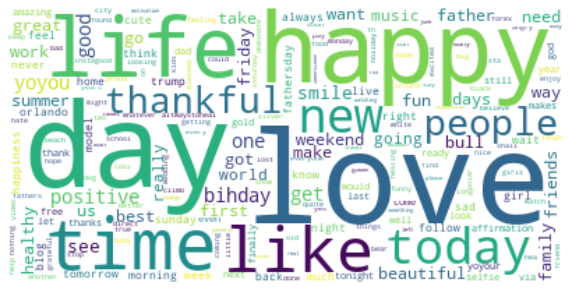

In [448]:
import collections
combine_df['tweet_lemmatized']=combine_df['tweet_lemmatized'].apply(lambda x: ' '.join([ch for ch in x]))
words = []
for line in combine_df['tweet_lemmatized']: 
    line_words = line.split()
    words.extend(line_words)

wordfreq = collections.Counter(words)
wordcloud = WordCloud(
 background_color='white',
 max_words=2000,
 stopwords=stopwords
 ).generate_from_frequencies(wordfreq)
plt.figure(figsize=(10,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Задание 5. Теперь отобразим облако слов для отзывов, не содержащих токсичных комментариев (combine_df['label'] == 0). 


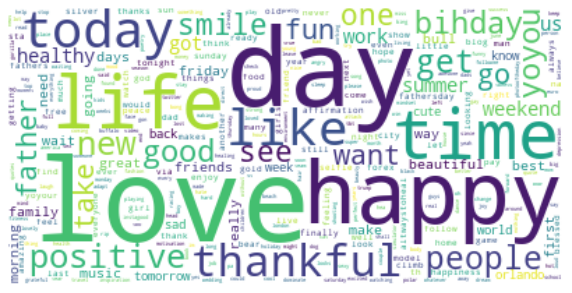

In [449]:
words = []
for line in combine_df[combine_df['label'] == 0]['tweet_lemmatized']: 
    line_words = line.split()
    words.extend(line_words)

wordfreq = collections.Counter(words)
wordcloud = WordCloud(
 background_color='white',
 max_words=2000,
 stopwords=stopwords
 ).generate_from_frequencies(wordfreq)
plt.figure(figsize=(10,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Задание 6. Теперь отобразим облако слов для отзывов, содержащих токсичные комментарии (combine_df['label'] == 1). 


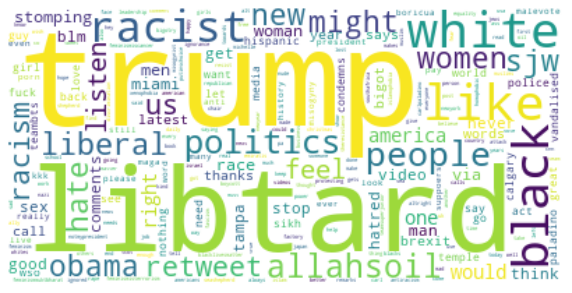

In [452]:
words = []
for line in combine_df[combine_df['label'] == 1]['tweet_lemmatized']: 
    line_words = line.split()
    words.extend(line_words)

wordfreq = collections.Counter(words)
wordcloud = WordCloud(
 background_color='white',
 max_words=2000,
 stopwords=stopwords
 ).generate_from_frequencies(wordfreq)
plt.figure(figsize=(10,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()